# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">4. Level 1 Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |



---

### **4. Level 1 Classification Notebook**
**Description:**
In this notebook, we will build and evaluate the **Level 1 Binary Classification model**, which separates the data into:
- Cases belonging to the two most common classes (e.g., **2 - NON-COMP** and **4 - TEMPORARY**).
- Cases classified as “**Other**” (all remaining classes).

Key steps include:
- Loading the **preprocessed dataset** created in Notebook 1.
- **Feature selection:** Identify features most relevant to this binary classification task.
- **Model training:** Train a binary classification model to distinguish between the "Common" and "Other" categories.
- **Evaluation:** Assess the performance of the Level 1 model using metrics like accuracy, precision, and recall.
- **Output:** Save predictions to pass data into the next stages (Level 2 Binary and Level 2 Multi-Class models).

This notebook ensures that data is efficiently routed into the appropriate paths for the subsequent levels.

---


<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [4.1. Preparing the Data](#section_4_1)  
    * [4.2. Numerical Features](#section_4_2) 
        * [4.2.1. LASSO Regression](#section_4_2_1)
        * [4.2.2. Recursive Feature Elimination - RFE](#section_4_2_2)
        * [4.2.3. Feature Importance - Decision Tree](#section_4_2_3)
        * [4.2.4. Feature Importance - Random Forest](#section_4_2_4)
    * [4.3. Categorical Features](#section_4_3)
        * [4.3.1. $\chi ^2$ Test for Independence](#section_4_3_1)
        * [4.3.2. Mutual Information Criterion (MIC)](#section_4_3_2)
    * [4.4. Final Features](#section_4_4)
* [5. Modelling](#chapter5)
* [6. Loading the results](#chapter6)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>
[Back to ToC](#toc)<br>


In [2]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier


# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')




from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances,compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics



In this topic we will also import the pre-saved feature categories dictionary from Notebook 3, ensuring consistency in feature grouping for feature selection and modeling.

In [3]:
# Load the feature categories dictionary
feature_categories_file = "feature_categories.pkl"
with open(feature_categories_file, "rb") as file:
    feature_categories = pickle.load(file)

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

Now that we preprocessed the dataset in notebook 3. we will upload those datasets

In [4]:
#Import the datasets
X_train = pd.read_csv("../processed_datasets/X_train_model.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_model.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../processed_datasets/df_test_model.csv", index_col="Claim Identifier")

In [5]:
X_train.head(5)

,Age at Injury,IME-4 Count,Agreement Reached,Income_Category,Accident_Quarter,Accident_Year,Accident Day,Age Group,promptness_category,promptness_C2_category,...,Industry Code_freq,County of Injury_freq,District Name_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier Name_freq,Body_Part_Category_freq,Injury_Nature_Category_freq,Carrier Type Merged_freq
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6099734,67,4.0,0.0,1,3,2022,3,1,3,3,...,34856,34897,216798,9648,44601,38469,11544,96343,404174,228492
5796182,30,0.0,0.0,1,3,2021,5,2,7,7,...,34856,13901,68763,6081,88312,15038,11163,96343,404174,228492
6128237,58,0.0,0.0,0,4,2022,3,0,7,7,...,2362,636,17442,11777,13917,6521,14012,80866,404174,228492
5394501,55,0.0,0.0,3,3,2019,5,0,1,1,...,29868,31684,216798,13345,44601,18172,5841,37241,404174,42169
5452763,25,0.0,0.0,2,1,2020,2,3,7,7,...,35389,10965,68763,29680,122811,15042,88862,142559,404174,88862


In [6]:
# Load the arrays
y_train = np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)
y_val =  np.load("../processed_datasets/y_val_preprocessed.npy", allow_pickle=True)

# 3. Setting the Target <a class="anchor" id="chapter3"></a>

[Back to ToC](#toc)<br>


In this section, we will analyze the distribution of the target variable to better understand its composition. This step is crucial for determining how to split the target into the two categories needed for the first level of the hierarchical classification: identifying the most common classes versus the "Other" category.

In [7]:
# Convert to Pandas Series and get value counts
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

2. NON-COMP        232862
4. TEMPORARY       118805
3. MED ONLY         55125
5. PPD SCH LOSS     38624
1. CANCELLED         9980
6. PPD NSL           3369
8. DEATH              376
7. PTD                 78
dtype: int64

In [14]:
# Create a mapping where 2. NON-COMP and 4. TEMPORARY are mapped to new targets
def map_to_majority_minority(y):
    """
    Map the original targets to new categories:
    - '2. NON-COMP' and '4. TEMPORARY' -> 'Majority Target'
    - All other classes -> 'Minority Target'
    """
    return np.where(np.isin(y, ['2. NON-COMP', '4. TEMPORARY']), 'Majority Target', 'Minority Target')

# Apply the mapping to y_train and y_val
y_train_mapped = map_to_majority_minority(y_train)
y_val_mapped = map_to_majority_minority(y_val)

# Ensure the original y_train and y_val are preserved
print("Original y_train classes:", np.unique(y_train))
print("Mapped y_train classes:", np.unique(y_train_mapped))
print("Mapped y_val classes:", np.unique(y_val_mapped))

Original y_train classes: ['1. CANCELLED' '2. NON-COMP' '3. MED ONLY' '4. TEMPORARY'
 '5. PPD SCH LOSS' '6. PPD NSL' '7. PTD' '8. DEATH']
Mapped y_train classes: ['Majority Target' 'Minority Target']
Mapped y_val classes: ['Majority Target' 'Minority Target']


In [15]:
# Convert to Pandas Series and get value counts
y_train_new_series = pd.Series(y_train_mapped)
y_train_new_series.value_counts()

Majority Target    351667
Minority Target    107552
Name: count, dtype: int64

In [16]:
# Convert to Pandas Series and get value counts
y_val_new_series = pd.Series(y_val_mapped)
y_val_new_series.value_counts()

Majority Target    87918
Minority Target    26887
Name: count, dtype: int64

**Encoding the Target**

In [17]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode y_train_new and y_val_new
y_train_encoded = encoder.fit_transform(y_train_mapped)  # Fit and transform on y_train_mapped
y_val_encoded = encoder.transform(y_val_mapped)  # Only transform on y_train_mapped

In [18]:
# Verify that the target is encoded 
print(f'y_train encoded: {y_train_encoded}')
print(f'y_val encoded: {y_val_encoded}')

y_train encoded: [0 1 0 ... 0 0 0]
y_val encoded: [0 0 0 ... 1 0 0]


# 4. Feature Selection <a class="anchor" id="chapter4"></a>

[Back to ToC](#toc)<br>


The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_train` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

In [19]:
# Displaying descriptive statistics for categorical features in the training dataset
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,459219.0,42.884970,12.952508,5.000000,33.0,42.00,53.0,82.0
IME-4 Count,459219.0,0.741481,1.913359,0.000000,0.0,0.00,0.0,25.0
Agreement Reached,459219.0,0.046468,0.210497,0.000000,0.0,0.00,0.0,1.0
Income_Category,459219.0,2.117887,1.205360,0.000000,1.0,2.00,3.0,4.0
Accident_Quarter,459219.0,2.485058,1.129401,1.000000,1.0,3.00,3.0,4.0
Accident_Year,459219.0,2020.822706,1.852020,1961.000000,2020.0,2021.00,2022.0,2023.0
Accident Day,459219.0,2.524671,1.828200,0.000000,1.0,2.00,4.0,6.0
Age Group,459219.0,1.337506,1.076315,0.000000,0.0,2.00,2.0,3.0
promptness_category,459219.0,4.370087,2.496478,0.000000,3.0,4.00,7.0,7.0
promptness_C2_category,459219.0,4.399069,2.505514,0.000000,3.0,4.00,7.0,7.0


In this section we will use the created dictionary in Notebook 3.

In [20]:
# Print summary
for category, features in feature_categories.items():
    print(f"{category.capitalize()} Features ({len(features)}):")
    print(features, "\n")

Categorical Features (6):
['Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Industry Risk'] 

Binary Features (5):
['Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_UK'] 

Numerical Features (18):
['Age at Injury', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Salary_Per_Dependent', 'Carrier_Name_Simplified_freq', 'Zip_Code_Simplified_freq', 'Industry Code_freq', 'County of Injury_freq', 'District Name_freq', 'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier Name_freq', 'Body_Part_Category_freq', 'Injury_Nature_Category_freq', 'Carrier Type Merged_freq'] 



## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>

[Back to 4. Feature Selection](#chapter4)<br>


To perform feature selection techniques like Lasso, RFE, and feature importance, the numerical features must first be scaled. Scaling ensures that all features have a consistent range, which is particularly important for methods sensitive to feature magnitude.

In this step, we will use the RobustScaler to standardize the numerical features in the dataset. This scaling process will be applied to a temporary dataset containing only the numerical features, allowing us to focus on selecting the most relevant features effectively. The scaled dataset will then be used as input for feature selection techniques.

In [21]:
# Extract numerical features from the dictionary
numerical_features = feature_categories["numerical"]

# Initialize RobustScaler
num_scaler = StandardScaler()

# Scale numerical features in X_train
X_train[numerical_features] = num_scaler.fit_transform(X_train[numerical_features])

X_train_num_scaled= X_train[numerical_features]

# Scale numerical features in X_val
X_val[numerical_features] = num_scaler.transform(X_val[numerical_features])

X_val_num_scaled= X_val[numerical_features]

**Variance Check After Scaling**

After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [22]:
# Check variance of scaled data
X_train_num_scaled.var()

Age at Injury                      1.000002
IME-4 Count                        1.000002
Accident_Quarter                   1.000002
Accident_Year                      1.000002
Accident Day                       1.000002
Salary_Per_Dependent               1.000002
Carrier_Name_Simplified_freq       1.000002
Zip_Code_Simplified_freq           1.000002
Industry Code_freq                 1.000002
County of Injury_freq              1.000002
District Name_freq                 1.000002
WCIO Cause of Injury Code_freq     1.000002
WCIO Nature of Injury Code_freq    1.000002
WCIO Part Of Body Code_freq        1.000002
Carrier Name_freq                  1.000002
Body_Part_Category_freq            1.000002
Injury_Nature_Category_freq        1.000002
Carrier Type Merged_freq           1.000002
dtype: float64

The output shows the variance of each numerical column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>
 [Back to 4. Feature Selection](#chapter4)<br>
 

### 4.2.1. LASSO Regression <a class="anchor" id="sub_section_4_2_1"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [23]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Carrier Type Merged_freq          -0.025871
Carrier_Name_Simplified_freq      -0.015131
Injury_Nature_Category_freq       -0.014424
District Name_freq                -0.012168
Accident_Quarter                  -0.006590
Accident_Year                     -0.006267
Zip_Code_Simplified_freq          -0.003563
WCIO Cause of Injury Code_freq    -0.002676
Accident Day                       0.000936
Industry Code_freq                 0.001721
Body_Part_Category_freq            0.008797
WCIO Part Of Body Code_freq        0.014429
WCIO Nature of Injury Code_freq    0.014825
Carrier Name_freq                  0.015833
Salary_Per_Dependent               0.017810
County of Injury_freq              0.019137
Age at Injury                      0.020500
IME-4 Count                        0.032451
dtype: float64

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

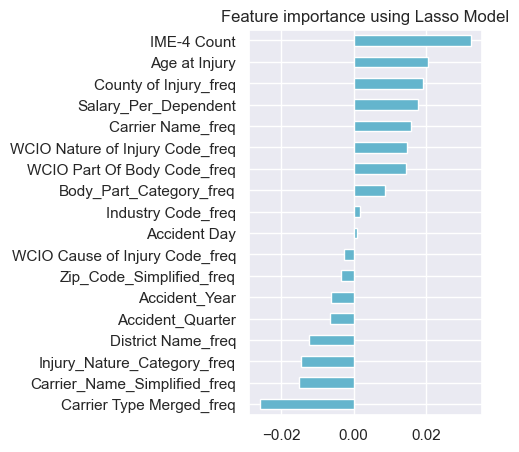

In [24]:
plot_importance(coef,'Lasso')

 ### 4.2.2. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_2"></a>

  [Back to 4.2. Numerical Features](#section_4_2)<br>
 

RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

The selected features after RFE likely overlap with those identified by LASSO, suggesting consistency in feature importance.
Using both LASSO and RFE provides a more robust feature selection by cross-validating the importance of individual features.

This block of code performs RFE to identify the best subset of features by iterating over a range of feature numbers. The code aims to maximize model performance on the validation set.

In [25]:
# RFE using Logistic Regression
model = LogisticRegression()

#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=19
)

Optimum number of features: 17
F1 Macro Score with 17 features: 0.436217



The loop evaluates models with 1 to 18 features, tracking the score for each.

The output indicates that 17 features yielded the highest validation f1_score score of 0.436202.

**Applying RFE with the Optimal Number of Features**

Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [26]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 17)

In [27]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [28]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Age at Injury                       True
IME-4 Count                         True
Accident_Quarter                    True
Accident_Year                       True
Accident Day                       False
Salary_Per_Dependent                True
Carrier_Name_Simplified_freq        True
Zip_Code_Simplified_freq            True
Industry Code_freq                  True
County of Injury_freq               True
District Name_freq                  True
WCIO Cause of Injury Code_freq      True
WCIO Nature of Injury Code_freq     True
WCIO Part Of Body Code_freq         True
Carrier Name_freq                   True
Body_Part_Category_freq             True
Injury_Nature_Category_freq         True
Carrier Type Merged_freq            True
dtype: bool

### 4.2.3. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_3"></a>
 [Back to 4.2. Numerical Features](#section_4_2)<br>



In [29]:
from utils import compare_feature_importances

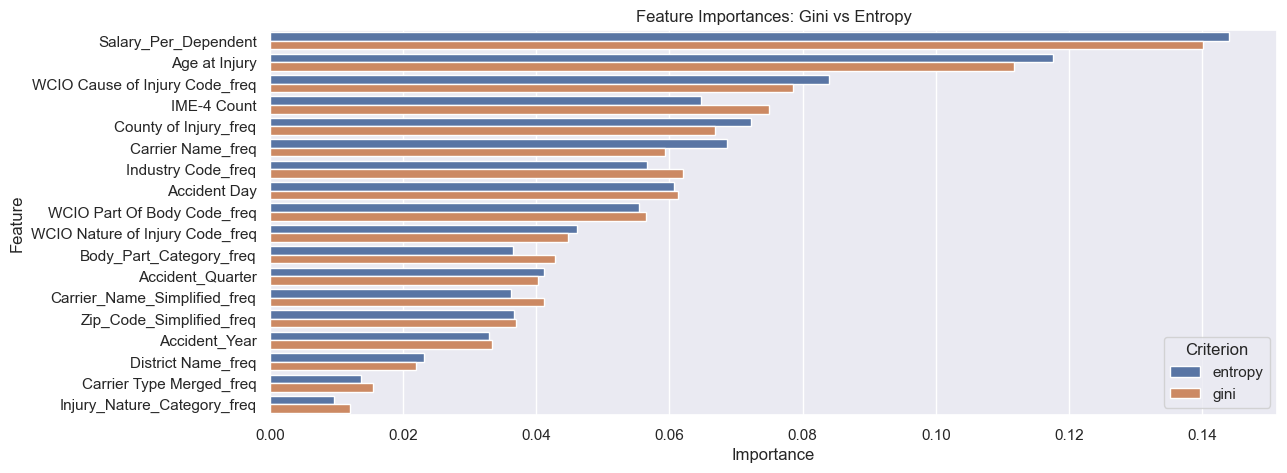

       gini   entropy               col
0  0.111730  0.117593     Age at Injury
1  0.074993  0.064764       IME-4 Count
2  0.040193  0.041202  Accident_Quarter
3  0.033312  0.032873     Accident_Year
4  0.061247  0.060723      Accident Day


In [30]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

### 4.2.4. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_4"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


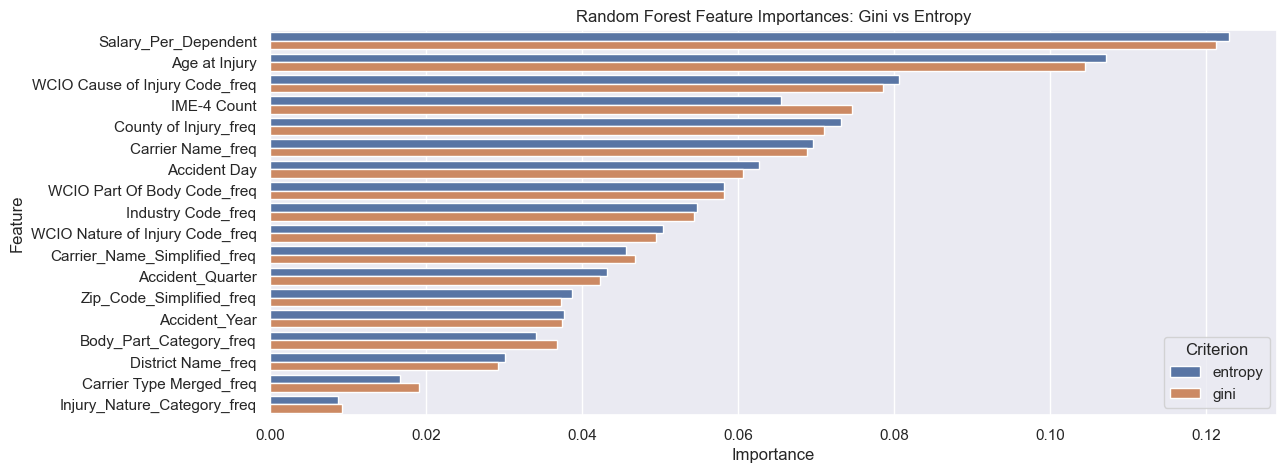

       gini   entropy               col
0  0.104489  0.107180     Age at Injury
1  0.074606  0.065525       IME-4 Count
2  0.042308  0.043158  Accident_Quarter
3  0.037509  0.037683     Accident_Year
4  0.060601  0.062649      Accident Day


In [31]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
[Back to 4. Feature Selection](#chapter4)<br>

Chi-squared and MIC for the categorical ones.

In [32]:
X_train_mic_chi2 = X_train[feature_categories['categorical'] + feature_categories['binary']]

In [33]:
X_train_mic_chi2.shape

(459219, 11)

In [34]:
X_train_mic_chi2.columns

Index(['Income_Category', 'Age Group', 'promptness_category',
       'promptness_C2_category', 'promptness_C3_category', 'Industry Risk',
       'Gender_M', 'Gender_U', 'Medical Fee Region_II',
       'Medical Fee Region_III', 'Medical Fee Region_UK'],
      dtype='object')

 ### 4.3.1. $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_3_1"></a>

[Back to 4.3. Categorical Features](#section_4_3)<br>


The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. 

In [35]:
from utils import select_high_score_features_chi2_no_model

In [36]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=6
)

Top 6 features based on Chi-square scores: ['promptness_C2_category', 'promptness_category', 'promptness_C3_category', 'Age Group', 'Income_Category', 'Gender_M']
Corresponding Chi-square scores: [3926.434088704915, 3561.501052874994, 3227.631195728296, 1354.5340717089923, 755.9224280930574, 542.3803735581471]


In [37]:
high_score_features_chi2

['promptness_C2_category',
 'promptness_category',
 'promptness_C3_category',
 'Age Group',
 'Income_Category',
 'Gender_M']

 ### 4.3.2. Mutual Information Criterion (MIC) <a class="anchor" id="sub_section_4_3_2"></a>

 [Back to 4.3. Categorical Features](#section_4_3)<br>
 

The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [38]:
from utils import select_high_score_features_MIC

In [39]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_mapped, 
    threshold=6, 
    random_state=42)

Top 6 features based on MIC scores: ['promptness_C3_category', 'Gender_M', 'Industry Risk', 'promptness_C2_category', 'Income_Category', 'promptness_category']
Corresponding MIC scores: [0.06354600947697531, 0.056096591683119756, 0.0478229509193957, 0.032932645977153285, 0.02716984611050166, 0.02595887783000439]


**Intersection of Selected Features by Chi-squared and MIC** <br>
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [40]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

['Gender_M',
 'promptness_category',
 'promptness_C3_category',
 'Income_Category',
 'promptness_C2_category']

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>
[Back to 4. Feature Selection](#chapter4)<br>

The following table evaluates all numerical features using multiple feature selection techniques: Spearman Correlation, LASSO Regression, RFE, Decision Tree, and Random Forest. Based on these combined insights, a final decision is provided in the "What to do?" column.


| **Predictor**                 | **Spearman**                       | **LASSO**         | **RFE**            | **Decision Tree Importance**   | **Random Forest Importance**  | **What to do?**               |
|-------------------------------|------------------------------------|-------------------|--------------------|--------------------------------|--------------------------------|--------------------------------|
| Carrier Type Merged_freq      | Low                                | Keep              | Keep               | Low                            | Low                            | Discard                       |
| Carrier_Name_Simplified_freq  | Low                                | Keep              | Keep               | Low                            | Low                            | Discard                       |
| Injury_Nature_Category_freq   | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| District Name_freq            | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| Accident_Quarter              | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| Accident_Year                 | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| Zip_Code_Simplified_freq      | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Cause of Injury Code_freq| Low                                | Discard           | Keep               | Keep                           | Keep                           | Include                       |
| Accident Day                  | Low                                | Discard           | Discard            | Keep                           | Low                            | Discard                       |
| Industry Code_freq            | Low                                | Discard           | Keep               | Keep                           | Low                            | Include                       |
| Body_Part_Category_freq       | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Part Of Body Code_freq   | Low                                | Discard           | Keep               | Low                            | Low                            | Discard                       |
| WCIO Nature of Injury Code_freq| Low                               | Discard           | Keep               | Low                            | Low                            | Discard                       |
| Carrier Name_freq             | Moderate                          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Salary_Per_Dependent          | Moderate                          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| County of Injury_freq         | Moderate                          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Age at Injury                 | Moderate                          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| IME-4 Count                   | Moderate                          | Keep              | Keep               | Keep                           | Keep                           | Include                       |

### **Categorical Feature Selection Results**

The following table summarizes the decisions for each categorical feature based on **Mutual Information (MIC)** and **Chi-Squared** (X²) results. The retained features will be used in subsequent modeling to enhance predictive performance.

| **Feature**              | **X² Results**          | **MIC Results**         | **Decision**               |
|---------------------------|-------------------------|-------------------------|----------------------------|
| promptness_C2_category | Keep                  | Keep                  | Include               |
| promptness_category    | Keep                 | -                       | Consider include in model                |
| promptness_C3_category | Keep                       | Keep                  | Include                |
| Age Group              | Keep                  | Keep                  | Include                |
| Income_Category        | Keep                  | Keep                  | Include                |
| Industry Risk         |                        | Keep                  | Consider include in model                |
| Gender_M               | Keep                  | Keep                  | Include                |
| Gender_U               | -                       | -                       | Exclude          |
| Medical Fee Region_II  | -                       | -                       | Exclude               |
| Medical Fee Region_III | -                       | -                       | Exclude               |
| Medical Fee Region_UK  | -                       | -                       | Exclude                |


In [41]:
numerical_features

['Age at Injury',
 'IME-4 Count',
 'Accident_Quarter',
 'Accident_Year',
 'Accident Day',
 'Salary_Per_Dependent',
 'Carrier_Name_Simplified_freq',
 'Zip_Code_Simplified_freq',
 'Industry Code_freq',
 'County of Injury_freq',
 'District Name_freq',
 'WCIO Cause of Injury Code_freq',
 'WCIO Nature of Injury Code_freq',
 'WCIO Part Of Body Code_freq',
 'Carrier Name_freq',
 'Body_Part_Category_freq',
 'Injury_Nature_Category_freq',
 'Carrier Type Merged_freq']

In [42]:
final_features = [
    # Categorical features selected through MIC and chi2
    'Age Group','promptness_C2_category',
    'Income_Category','Gender_M', 'promptness_C3_category',
    # Important numerical features
    'Age at Injury', 'IME-4 Count','Salary_Per_Dependent','Industry Code_freq',
    'County of Injury_freq','WCIO Part Of Body Code_freq','WCIO Cause of Injury Code_freq',
    'Carrier Name_freq']


# Extracting the final features from the processed datasets
X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = df_test[final_features]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (459219, 13)
X_val_final shape: (114805, 13)
X_test_final shape: (387975, 13)


In [43]:
len(y_train_encoded)

459219

In [44]:
len(y_val_encoded)

114805

In [45]:
# # Importando bibliotecas
# import numpy as np
# import pandas as pd
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import SMOTE

# # Aplicando SMOTE para balancear as classes novamente
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train_encoded)

# # Treinando modelos individuais
# print("Treinando Random Forest...")
# random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
# random_forest.fit(X_train_balanced, y_train_balanced)

# print("Treinando XGBoost...")
# xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgboost.fit(X_train_balanced, y_train_balanced)

# print("Treinando Logistic Regression...")
# logistic_regression = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
# logistic_regression.fit(X_train_balanced, y_train_balanced)

# # Obter probabilidades de cada modelo
# rf_probs = random_forest.predict_proba(X_val_final)[:, 1]  # Probabilidades da classe 1
# xgb_probs = xgboost.predict_proba(X_val_final)[:, 1]       # Probabilidades da classe 1
# lr_probs = logistic_regression.predict_proba(X_val_final)[:, 1]  # Probabilidades da classe 1

# # Criar ensemble com pesos ajustados
# weights = [0.3, 0.5, 0.2]  # Pesos ajustados: XGBoost tem maior peso
# ensemble_probs = (weights[0] * rf_probs + weights[1] * xgb_probs + weights[2] * lr_probs)

# # Ajustar threshold
# threshold = 0.4  # Threshold ajustado para melhorar recall da classe 1
# ensemble_preds = (ensemble_probs > threshold).astype(int)

# # Avaliar desempenho do ensemble
# print("Resultados do Ensemble:")
# print(classification_report(y_val_encoded, ensemble_preds))
# print("Matriz de Confusão:")
# print(confusion_matrix(y_val_encoded, ensemble_preds))

# # Comparação com os modelos individuais
# print("\nResultados Comparativos:")
# rf_report = classification_report(y_val_encoded, random_forest.predict(X_val_final), output_dict=True)
# xgb_report = classification_report(y_val_encoded, xgboost.predict(X_val_final), output_dict=True)
# lr_report = classification_report(y_val_encoded, logistic_regression.predict(X_val_final), output_dict=True)
# ensemble_report = classification_report(y_val_encoded, ensemble_preds, output_dict=True)

# # Organizando resultados em um DataFrame
# comparison = pd.DataFrame({
#     "Random Forest": [rf_report['1']['precision'], rf_report['1']['recall'], rf_report['1']['f1-score']],
#     "XGBoost": [xgb_report['1']['precision'], xgb_report['1']['recall'], xgb_report['1']['f1-score']],
#     "Logistic Regression": [lr_report['1']['precision'], lr_report['1']['recall'], lr_report['1']['f1-score']],
#     "Ensemble": [ensemble_report['1']['precision'], ensemble_report['1']['recall'], ensemble_report['1']['f1-score']]
# }, index=["Precision", "Recall", "F1-Score"])
# print(comparison)

# # Exibindo gráfico comparativo
# comparison.plot(kind='bar', figsize=(10, 6), title="Comparação de Desempenho (Classe 1)")

In [46]:
# # Garantir que X_test_final seja um DataFrame original
# X_test_final_original = X_test_final.copy()

# # Obter probabilidades de cada modelo no conjunto de teste
# rf_test_probs = random_forest.predict_proba(X_test_final_original)[:, 1]  # Probabilidades da classe 1
# xgb_test_probs = xgboost.predict_proba(X_test_final_original)[:, 1]       # Probabilidades da classe 1
# lr_test_probs = logistic_regression.predict_proba(X_test_final_original)[:, 1]  # Probabilidades da classe 1

# # Criar ensemble no conjunto de teste
# ensemble_test_probs = (weights[0] * rf_test_probs + weights[1] * xgb_test_probs + weights[2] * lr_test_probs)

# # Aplicar o threshold ajustado
# ensemble_test_preds = (ensemble_test_probs > threshold).astype(int)

# # Adicionar previsões ao X_test_final_original
# X_test_final_original['Classe_Prevista'] = ensemble_test_preds

# # Exportar o DataFrame final
# X_test_final_original.to_csv("X_test_final_com_previsoes.csv", index=True)

# # Exibir as primeiras linhas do DataFrame exportado
# print("Previsões no conjunto de teste exportadas:")
# print(X_test_final_original.head())


MELHOR MODELO

In [47]:
# Importação de bibliotecas
#import numpy as np
#import pandas as pd
#from sklearn.metrics import classification_report, confusion_matrix, f1_score
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
#from sklearn.model_selection import StratifiedKFold
#from imblearn.over_sampling import SMOTE
#import lightgbm as lgb

# Aplicando SMOTE para balancear as classes no treino
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train_encoded)

# Parâmetros
#N_FOLDS = 5  # Número de folds para cross-validation
#SEED = 42

# Modelos base
#models = {
#    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=SEED),
#    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=5, random_state=SEED),
#    "LightGBM": lgb.LGBMClassifier(n_estimators=200, max_depth=5, random_state=SEED),
#    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=SEED)
#}

# Inicializar previsões out-of-fold
#oof_preds = np.zeros((len(X_val_final), len(models)))
#skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Treinar cada modelo base com Cross-Validation
#print("Treinando modelos base com Cross-Validation...")
#for idx, (name, model) in enumerate(models.items()):
#    print(f"Treinando {name}...")
#    fold_preds = np.zeros(len(X_val_final))
#    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_balanced, y_train_balanced)):
#        print(f"  Fold {fold + 1}/{N_FOLDS}")
#        X_train_fold, y_train_fold = X_train_balanced.iloc[train_idx], y_train_balanced[train_idx]
#        X_val_fold, y_val_fold = X_train_balanced.iloc[val_idx], y_train_balanced[val_idx]
#        
#        # Balancear com SMOTE dentro de cada fold
#        X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y_train_fold)
#        
#        # Treinar modelo
#        model.fit(X_train_fold_sm, y_train_fold_sm)
#        
#        # Fazer previsões no conjunto de validação
#        fold_preds += model.predict_proba(X_val_final)[:, 1] / N_FOLDS
    
#    oof_preds[:, idx] = fold_preds  # Armazenar previsões OOF

## Treinar meta-modelo usando as previsões OOF
#print("Treinando meta-modelo (XGBoost)...")
#meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
#meta_model.fit(oof_preds, y_val_encoded)

# Obter previsões finais do ensemble
#final_probs = meta_model.predict_proba(oof_preds)[:, 1]

# Otimizar threshold
#def optimize_threshold(probs, y_true):
#    best_threshold, best_f1 = 0, 0
#    for threshold in np.arange(0.1, 0.9, 0.01):
#        preds = (probs > threshold).astype(int)
#        f1 = f1_score(y_true, preds, average='macro')
#        if f1 > best_f1:
#            best_f1, best_threshold = f1, threshold
#    return best_threshold

#best_threshold = optimize_threshold(final_probs, y_val_encoded)
#final_preds = (final_probs > best_threshold).astype(int)

# Avaliar desempenho do ensemble
#print("\nResultados do Ensemble com Stacking:")
#print(classification_report(y_val_encoded, final_preds))
#print("Matriz de Confusão:")
#print(confusion_matrix(y_val_encoded, final_preds))

# Comparação de F1-Score Macro
#comparison = pd.DataFrame({
#    "Meta-Model Ensemble": [f1_score(y_val_encoded, final_preds, average='macro')]
#}, index=["Macro F1-Score"])

#print("\nComparação de Desempenho:")
#print(comparison)


# 5. Modeling <a class="anchor" id="chapter5"></a>

[Back to ToC](#toc)<br>

## 5.1. Logistic Regression</b> <a class="anchor" id="section_5_1"></a>

[Back to 5. Modeling](#chapter5)<br>


**Standard Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------


              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.40      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.58      0.50      0.44    459219
weighted avg       0.68      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87     87918
           1       0.36      0.01      0.02     26887

    accuracy                           0.76    114805
   macro avg       0.56      0.50      0.44    114805
weighted avg       0.67      0.76      0.67    114805



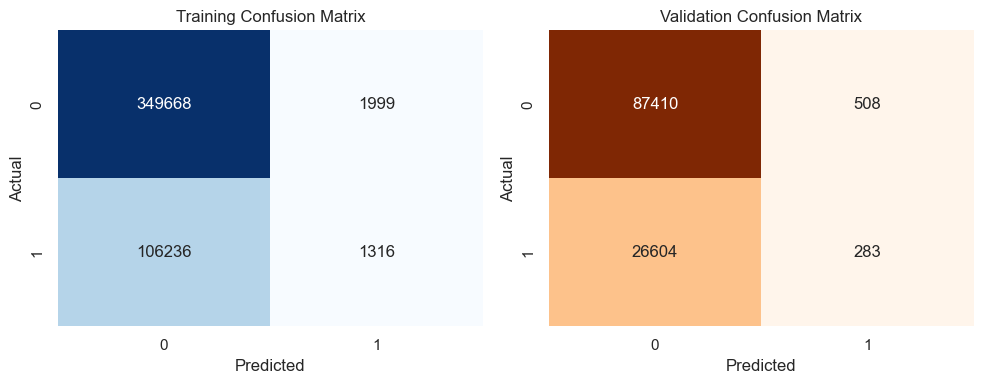

In [48]:
# Scale features
scaler_log = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler_log.fit_transform(X_train_final)

# Transform validation and test data using the same scaler
X_val_scaled = scaler_log.transform(X_val_final)
X_test_scaled = scaler_log.transform(X_test_final)

# Logistic Regression Model
log_reg_std = LogisticRegression(max_iter=1000, random_state=42)
log_reg_std.fit(X_train_scaled, y_train_encoded)

# Predictions on training and validation sets
pred_train_log_final_std = log_reg_std.predict(X_train_scaled)  # Corrected for training data
pred_val_log_final_std = log_reg_std.predict(X_val_scaled)      # Validation data

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_std, y_val_encoded, pred_val_log_final_std)

**Min Max Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.40      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.58      0.50      0.45    459219
weighted avg       0.68      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

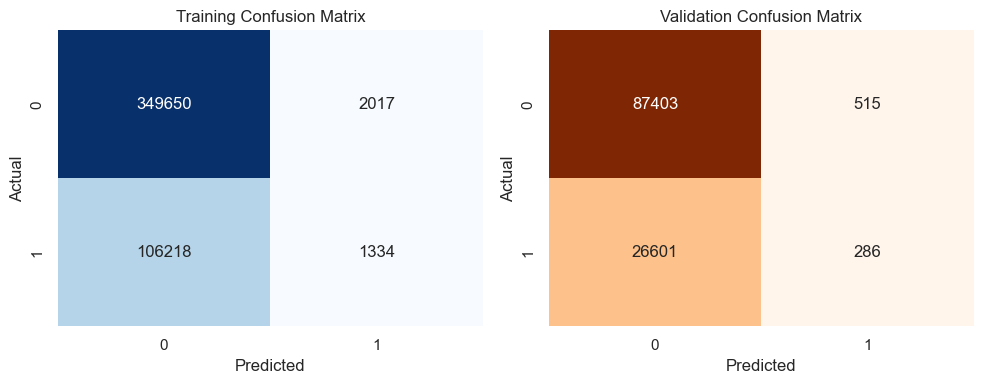

In [49]:
# Scale features
scaler = MinMaxScaler()
final_features_X_train_scaled_minmax = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_minmax = scaler.transform(X_val_final)
final_features_df_test_scaled_minmax = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_minmax = LogisticRegression(max_iter=1000, random_state=42)
log_reg_minmax.fit(final_features_X_train_scaled_minmax, y_train_encoded)
pred_train_log_final_minmax = log_reg_minmax.predict(final_features_X_train_scaled_minmax)
pred_val_log_final_minmax = log_reg_minmax.predict(final_features_X_val_scaled_minmax)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_minmax, y_val_encoded, pred_val_log_final_minmax)

**Robust Scaler**

Logistic Regression Metrics:
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.99      0.87    351667
           1       0.40      0.01      0.02    107552

    accuracy                           0.76    459219
   macro avg       0.58      0.50      0.44    459219
weighted avg       0.68      0.76      0.67    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
--------------------------------------------------------------------------------------------------------

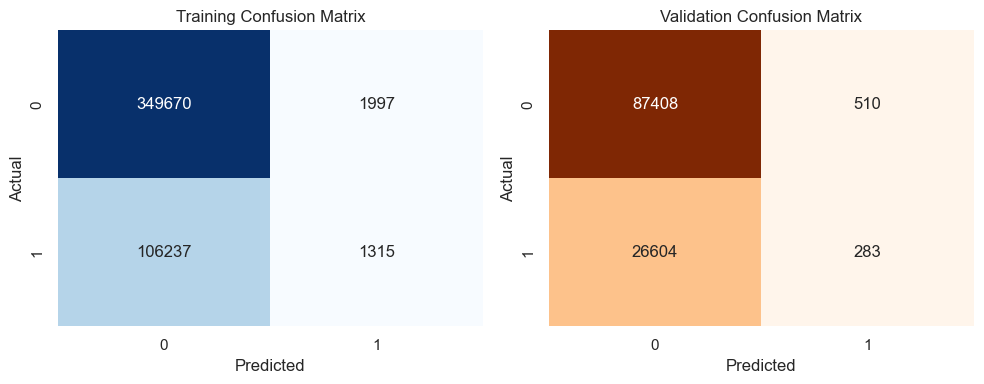

In [50]:
# Scale features
scaler = RobustScaler()
final_features_X_train_scaled_rob = scaler.fit_transform(X_train_final)
final_features_X_val_scaled_rob = scaler.transform(X_val_final)
final_features_df_test_scaled_rob = scaler.transform(X_test_final)

# Logistic Regression Model
log_reg_rob = LogisticRegression(max_iter=1000, random_state=42)
log_reg_rob.fit(final_features_X_train_scaled_rob, y_train_encoded)
pred_train_log_final_rob = log_reg_rob.predict(final_features_X_train_scaled_rob)
pred_val_log_final_rob = log_reg_rob.predict(final_features_X_val_scaled_rob)

# Metrics for Logistic Regression
print("Logistic Regression Metrics:")
metrics(y_train_encoded, pred_train_log_final_rob, y_val_encoded, pred_val_log_final_rob)

##### Train test Split
| Model Name | Scaler | Resampling Technique | F1 Score (Train)| F1 Score (Validation)|
|------------|-------------|----------------------|------------------|-----------------------|
| Logistic Regression | Standard | None  |     0.59       |      0.61             |
| Logistic Regression | MinMax | None  |         0.59         |        0.60              | 
| Logistic Regression  | Robust | None   |          0.59      |        0.60          |  

## 5.2. KNN</b> <a class="anchor" id="section_5_2"></a>
[Back to 5. Modeling](#chapter5)<br>

## KNN DEMORA BUE QUEREMOS MM ISTO?


**Standard Scaler**

In [51]:
# # K-Nearest Neighbors Model

# knn_std = KNeighborsClassifier(n_neighbors=6)
# knn_std.fit(X_train_scaled, y_train_encoded)
# pred_train_knn_final_std = knn_std.predict(X_train_scaled)
# pred_val_knn_final_std = knn_std.predict(X_val_scaled)

# # Metrics for K-Nearest Neighbors
# print("\nK-Nearest Neighbors Metrics:")
# metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)

### __`KNN Standard Scaler CV`__

In [52]:

# # Initialize the KNN model with 6 neighbors
# knn_std = KNeighborsClassifier(n_neighbors=6)

# # Define K-Fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation for KNN
# cv_scores_knn = cross_val_score(knn_std, final_features_X_train_scaled_std, y_train_encoded, cv=kf, scoring='f1_macro')

# # Print cross-validation results
# print("K-Nearest Neighbors Cross-Validation Scores:", cv_scores_knn)
# print("Mean Cross-Validation Score for K-Nearest Neighbors:", cv_scores_knn.mean())

# # Fit the KNN model on the full training data after cross-validation
# knn_std.fit(final_features_X_train_scaled_std, y_train_encoded)

# # Calculate metrics for training and validation sets
# pred_train_knn_final_std = knn_std.predict(final_features_X_train_scaled_std)
# pred_val_knn_final_std = knn_std.predict(final_features_X_val_scaled_std)

# # Metrics for K-Nearest Neighbors
# print("\nK-Nearest Neighbors Metrics:")
# metrics(y_train_encoded, pred_train_knn_final_std, y_val_encoded, pred_val_knn_final_std)

| Model Name              | Scaler | Split Method     | F1 Score (Train) | F1 Score (Validation) |
|--------------------------|------------------|------------------|------------------|-----------------------|
| KNN  | Standard | Train Test Split  |       0.68        |      0.62           |  
| KNN | Standard | Stratified K-Fold  |       0.67       |         0.57           | 

## 5.3. Decision Trees</b> <a class="anchor" id="section_5_3"></a>

[Back to 5. Modeling](#chapter5)<br>


___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    351667
           1       1.00      1.00      1.00    107552

    accuracy                           1.00    459219
   macro avg       1.00      1.00      1.00    459219
weighted avg       1.00      1.00      1.00    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

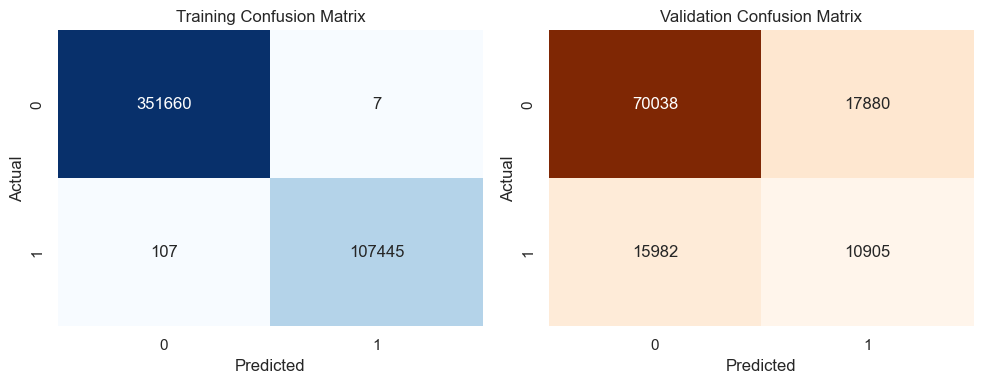

In [53]:
# Decision Tree Model
dt_std = DecisionTreeClassifier(random_state=42)

# Fit model with final features
dt_std.fit(X_train_scaled, y_train_encoded)
y_pred_dt_final = dt_std.predict(X_train_scaled)

# Metrics for Decision Tree
dt_std.fit(X_train_scaled, y_train_encoded)
pred_train_dt_final_std = dt_std.predict(X_train_scaled)
pred_val_dt_final_std = dt_std.predict(X_val_scaled)
metrics(y_train_encoded, pred_train_dt_final_std, y_val_encoded, pred_val_dt_final_std)

Fit Decision Tree model with pruning parameters for final features and potential value features since we have overfitting

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.98      0.87    351667
           1       0.71      0.13      0.22    107552

    accuracy                           0.78    459219
   macro avg       0.75      0.56      0.55    459219
weighted avg       0.77      0.78      0.72    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

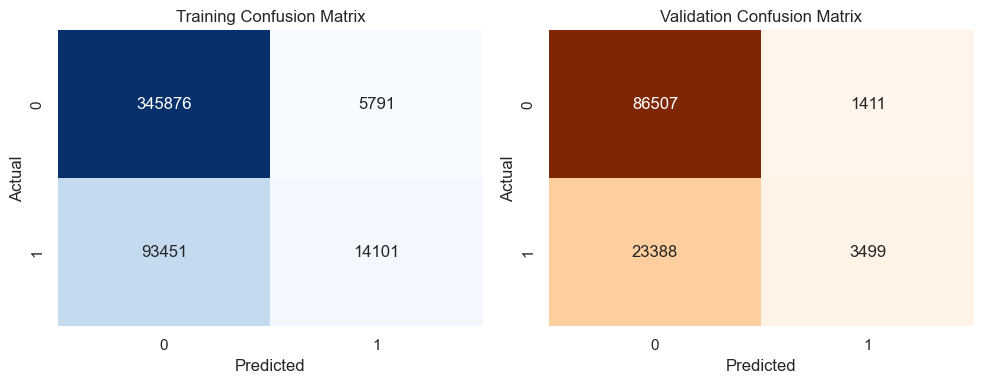

In [54]:
# Pruned Decision Tree Classifier
pruned_dt_std = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split =150, min_samples_leaf=150)

# Fit pruned Decision Tree model with final features and calculate metrics for training and validation
pruned_dt_std.fit(X_train_scaled, y_train_encoded)
pred_train_pruned_dt_std = pruned_dt_std.predict(X_train_scaled)
pred_val_pruned_dt_std = pruned_dt_std.predict(X_val_scaled)
metrics(y_train_encoded, pred_train_pruned_dt_std, y_val_encoded, pred_val_pruned_dt_std)

| Model Name | Scaler | Resampling Technique | F1 Score (Train)| F1 Score (Validation)|
|------------|-------------|----------------------|------------------|-----------------------|
| Decision Tree  | Standard | None  |        1     |        0.6       |
| Pruned Decision Tree | Standard | None  |       0.58       |       0.58             |

---

## 5.4. Random Forest</b> <a class="anchor" id="section_5_4"></a>
[Back to 5. Modeling](#chapter5)<br>


Cross-validation scores: [0.52777255 0.5258396  0.52306773 0.52901839 0.52623657]
Mean cross-validation score: 0.5263869695798821
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.99      0.88    351667
           1       0.83      0.10      0.18    107552

    accuracy                           0.78    459219
   macro avg       0.81      0.55      0.53    459219
weighted avg       0.79      0.78      0.71    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---

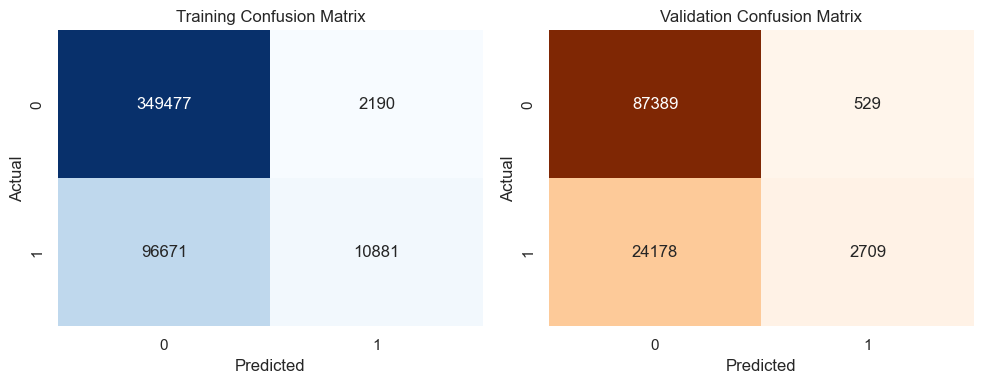

In [55]:
# Initialize the Random Forest model
rf_std = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_std, X_train_scaled, y_train_encoded, cv=kf, scoring='f1_macro')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# After cross-validation, fit the model on the full training data
rf_std.fit(X_train_scaled, y_train_encoded)

# Calculate metrics for training and validation sets
pred_train_rf_std = rf_std.predict(X_train_scaled)
pred_val_rf_std = rf_std.predict(X_val_scaled)
metrics(y_train_encoded, pred_train_rf_std, y_val_encoded, pred_val_rf_std)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.99      0.88    351667
           1       0.83      0.10      0.18    107552

    accuracy                           0.78    459219
   macro avg       0.81      0.55      0.53    459219
weighted avg       0.79      0.78      0.71    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

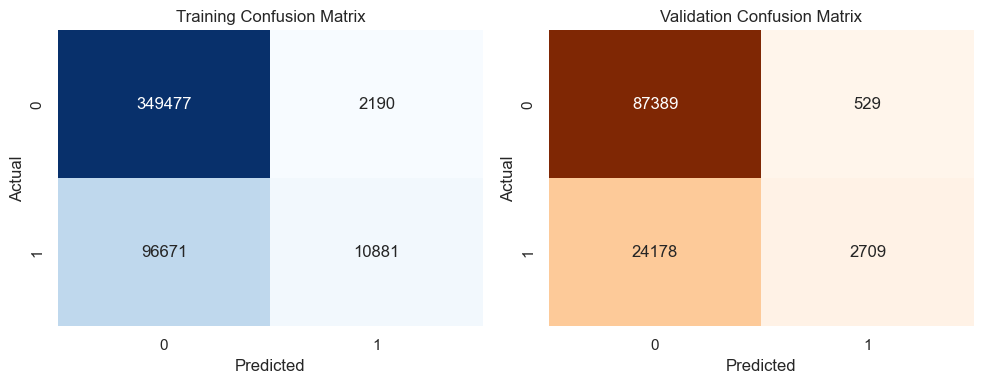

In [56]:
# Random Forest Classifier
rf_std = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Fit Random Forest model with final features and calculate metrics for training and validation
rf_std.fit(X_train_scaled, y_train_encoded)
pred_train_rf_std= rf_std.predict(X_train_scaled)
pred_val_rf_std = rf_std.predict(X_val_scaled)
metrics(y_train_encoded, pred_train_rf_std, y_val_encoded, pred_val_rf_std)

| Model Name | Scaler | Split Method | F1 Score (Train)| F1 Score (Validation)| 
|------------|-------------|----------------------|------------------|-----------------------|
| Random Forest  | Standard | Cross Validation  |     0.58        |        0.58    |
| Random Forest  | Standard | Train Test Split  |      0.58      |     0.58        |


---

## 5.5. Ensemble Methods </b> <a class="anchor" id="section_5_5"></a>

[Back to 5. Modeling](#chapter5)<br>

 ### 5.5.1. Boosting <a class="anchor" id="sub_section_5_5_1"></a>

> ### Gradient Boosting

#### __`XGBClassifier`__

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.96      0.88    351667
           1       0.71      0.28      0.41    107552

    accuracy                           0.81    459219
   macro avg       0.76      0.62      0.64    459219
weighted avg       0.79      0.81      0.77    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

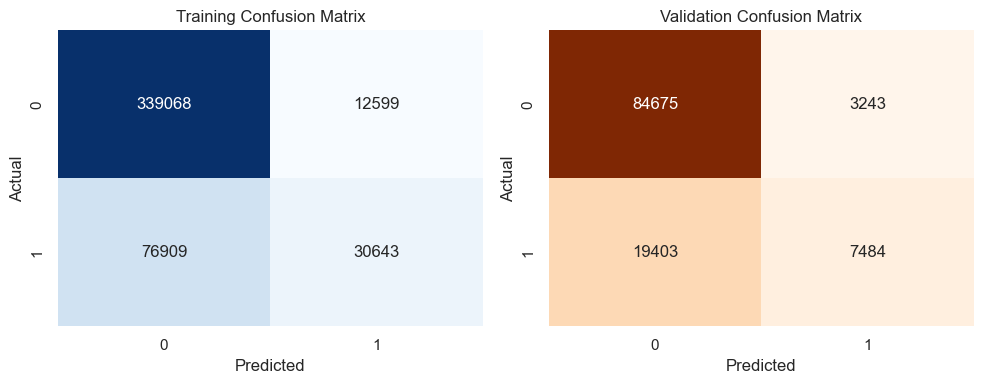

In [57]:
# XGBoost Classifier
xgb_std = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit XGBoost model with final features and calculate metrics for training and validation
xgb_std.fit(X_train_scaled, y_train_encoded)
pred_train_xgb_std = xgb_std.predict(X_train_scaled)
pred_val_xgb_std = xgb_std.predict(X_val_scaled)

metrics(y_train_encoded, pred_train_xgb_std, y_val_encoded, pred_val_xgb_std)

#### __`CatBoost (CatBoostClassifier)`__ <br>
CatBoost is a gradient boosting framework designed to natively support categorical features. It is efficient, easy to implement, and often performs well on tabular data.

0:	learn: 0.1925075	test: 0.1923745	best: 0.1923745 (0)	total: 78.8ms	remaining: 7.8s
10:	learn: 0.2354626	test: 0.2358029	best: 0.2380130 (2)	total: 230ms	remaining: 1.86s
20:	learn: 0.2356489	test: 0.2366146	best: 0.2401378 (17)	total: 387ms	remaining: 1.46s
30:	learn: 0.2466690	test: 0.2479225	best: 0.2479225 (30)	total: 544ms	remaining: 1.21s
40:	learn: 0.2651406	test: 0.2659947	best: 0.2659947 (40)	total: 701ms	remaining: 1.01s
50:	learn: 0.2860705	test: 0.2888508	best: 0.2888508 (50)	total: 851ms	remaining: 817ms
60:	learn: 0.3018494	test: 0.3029065	best: 0.3029065 (60)	total: 1s	remaining: 640ms
70:	learn: 0.3098334	test: 0.3114947	best: 0.3114947 (70)	total: 1.16s	remaining: 475ms
80:	learn: 0.3180562	test: 0.3207865	best: 0.3207865 (80)	total: 1.32s	remaining: 309ms
90:	learn: 0.3264368	test: 0.3293115	best: 0.3293115 (90)	total: 1.52s	remaining: 151ms
99:	learn: 0.3323839	test: 0.3358587	best: 0.3358587 (99)	total: 1.67s	remaining: 0us

bestTest = 0.3358586581
bestIteration =

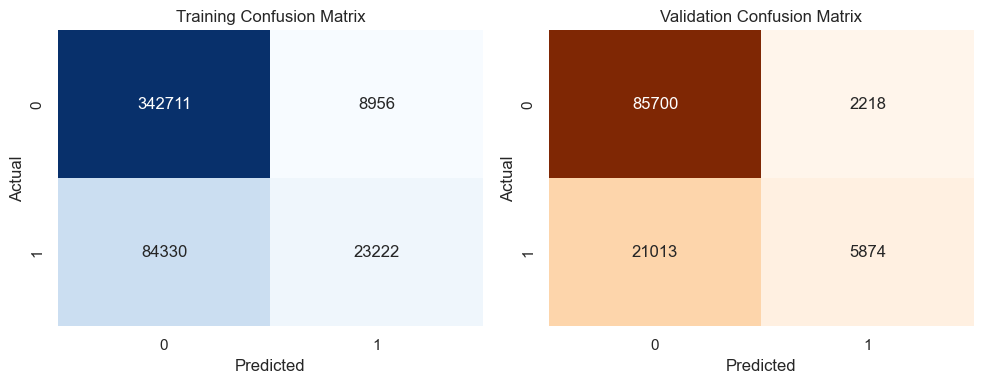

In [58]:
# Scale numerical features (CatBoost does not require scaling, but we'll keep it for consistency)

# Initialize CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,                # Number of boosting iterations
    learning_rate=0.1,             # Step size for gradient descent
    depth=6,                       # Depth of the tree
    random_seed=42,                # Random seed for reproducibility
    eval_metric='F1',              # Metric for evaluation
    verbose=10,                    # Display training progress every 10 iterations
    # No need to specify cat_features since all features are numeric
)

# Train the CatBoost model
catboost_model.fit(
    X_train_scaled, y_train_encoded,
    eval_set=(X_val_scaled, y_val_encoded),  # Validation set for monitoring
    use_best_model=True,  # Save the best iteration during training
    plot=False            # Set to True if you want a training plot
)

# Make predictions
train_preds = catboost_model.predict(X_train_scaled)
val_preds = catboost_model.predict(X_val_scaled)

metrics(y_train_encoded, train_preds, y_val_encoded, val_preds)


#### __`HyperTuning XgBoost`__ <br>

In [59]:
# Scale features (optional step, XGBoost handles unscaled features well)

# Define the XGBoost model
xgb = XGBClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the best F1 Macro score
print(f"Best parameters found: {best_params}")
print(f"Best F1 Macro score from GridSearchCV: {best_score:.4f}")

# Retrain the best model on the full training set
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; tota

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    351667
           1       0.77      0.35      0.48    107552

    accuracy                           0.82    459219
   macro avg       0.80      0.66      0.69    459219
weighted avg       0.82      0.82      0.80    459219

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision  

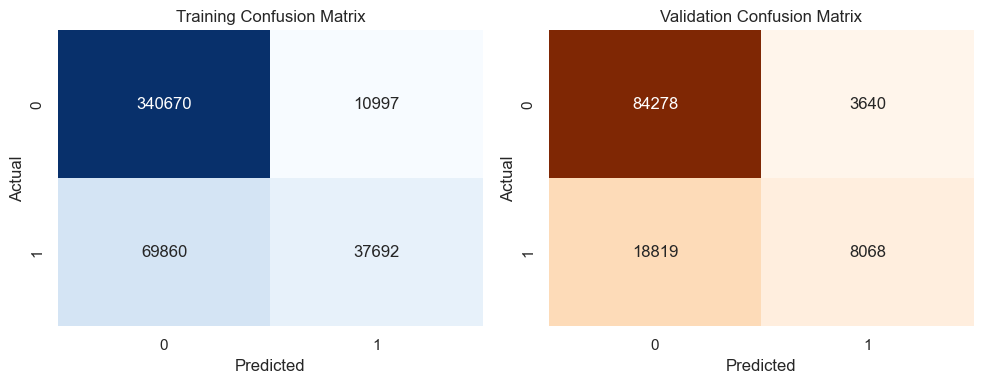

In [60]:
#Make predictions on the training set
train_preds = best_xgb_model.predict(X_train_scaled)

# Make predictions on the validation set
val_preds = best_xgb_model.predict(X_val_scaled)

# Calculate metrics for training and validation sets
metrics(y_train_encoded, train_preds, y_val_encoded, val_preds)

> ### AdaBoost

In [61]:

# # Initialize AdaBoost with a DecisionTreeClassifier as the base estimator
# base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)  # Weak learner
# adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)

# # Train the AdaBoost model
# adaboost.fit(X_train_scaled, y_train_encoded)

# # Make predictions
# train_preds = adaboost.predict(X_train_scaled)
# val_preds = adaboost.predict(X_val_scaled)

# metrics(y_train_encoded, train_preds, y_val_encoded, val_preds)


---

In [62]:
# # Scale features
# scaler = StandardScaler()
# final_features_X_train_scaled_std = scaler.fit_transform(X_train_final)
# final_features_X_val_scaled_std = scaler.transform(X_val_final)
# final_features_df_test_scaled_std = scaler.transform(X_test_final)

# # Initialize the models
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# xgb = XGBClassifier(n_estimators=100, random_state=42)

# # Create a VotingClassifier (ensemble)
# ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='hard')  # For hard voting

# # Train the individual models
# rf.fit(final_features_X_train_scaled_std, y_train_encoded)
# xgb.fit(final_features_X_train_scaled_std, y_train_encoded)

# # Train the ensemble model
# ensemble.fit(final_features_X_train_scaled_std, y_train_encoded)

# # Make predictions on the validation set
# rf_train_preds = rf.predict(final_features_X_train_scaled_std)
# rf_val_preds = rf.predict(final_features_X_val_scaled_std)

# xgb_train_preds = xgb.predict(final_features_X_train_scaled_std)
# xgb_val_preds = xgb.predict(final_features_X_val_scaled_std)

# ensemble_train_preds = ensemble.predict(final_features_X_train_scaled_std)
# ensemble_val_preds = ensemble.predict(final_features_X_val_scaled_std)

# # Calculate F1 Macro score
# rf_f1_train = f1_score(y_train_encoded, rf_train_preds, average='macro')
# rf_f1_val = f1_score(y_val_encoded, rf_val_preds, average='macro')

# xgb_f1_train = f1_score(y_train_encoded, xgb_train_preds, average='macro')
# xgb_f1_val = f1_score(y_val_encoded, xgb_val_preds, average='macro')

# ensemble_f1_train = f1_score(y_train_encoded, ensemble_train_preds, average='macro')
# ensemble_f1_val = f1_score(y_val_encoded, ensemble_val_preds, average='macro')

# # Print the F1 Macro scores
# print(f"Random Forest F1 Macro - Train: {rf_f1_train:.4f}, Validation: {rf_f1_val:.4f}")
# print(f"XGBoost F1 Macro - Train: {xgb_f1_train:.4f}, Validation: {xgb_f1_val:.4f}")
# print(f"Ensemble F1 Macro - Train: {ensemble_f1_train:.4f}, Validation: {ensemble_f1_val:.4f}")

# # Uncomment the following block if predictions on the test dataset are required
# # Make predictions on the test dataset
# # test_preds = ensemble.predict(final_features_df_test_scaled_std)

# # Save the predictions to a CSV file
# # test_predictions_df = pd.DataFrame(test_preds, columns=['Predictions'])
# # test_predictions_df.to_csv('test_predictions.csv', index=False)
# # print("Test predictions saved to 'test_predictions.csv'.")


> ## XGBoost

| Model Name | Scaler | Split Method | F1 Score (Train)| F1 Score (Validation)| 
|------------|-------------|----------------------|------------------|-----------------------|
| XGBoost | Standard | Train Test Split  |        0.70     |    0.70         |

 ### 5.5.2. Bagging <a class="anchor" id="sub_section_5_5_2"></a>

In [63]:
# from sklearn.model_selection import RepeatedStratifiedKFold

In [64]:
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

In [65]:
# def return_f1score(model, X, y):
#     n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
#     return n_scores

In [66]:
# def return_results(models):
#     results, names = [],[]
#     for name, model in models.items():
#         scores = return_f1score(model, final_features_X_train_scaled_std, y_train_encoded)
#         results.append(scores)
#         names.append(name)
#         print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
#     plt.figure(figsize=(15,7))
#     plt.boxplot(results, labels = names, showmeans = True)
#     plt.xticks(fontsize=14)
#     plt.show()

In [67]:
# print(final_features_X_train_scaled_std)

In [68]:
# dt = DecisionTreeClassifier()
# knn = KNeighborsClassifier()

# def get_models(*args):
#     models = dict()
#     for arg in args:
#         models[str(arg)] = arg
#         models[str(arg) + '_bagging'] = BaggingClassifier(estimator = arg, random_state = 15)      
#     return models

# models = get_models(dt, knn)
# return_results(models)

---

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import ParameterGrid

# Define base classifiers
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

def get_models(*args):
    """Generates models with BaggingClassifier using different parameter combinations."""
    models = dict()
    
    # Define parameters to be tested in BaggingClassifier
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]
    }
    
    # Generate parameter combinations
    grid = list(ParameterGrid(param_grid))

    for arg in args:
        # Add the base model
        models[str(arg)] = arg
        
        # Add models with BaggingClassifier for each parameter combination
        for i, params in enumerate(grid):
            # Only set oob_score=True if bootstrap is also True
            if params['oob_score'] and not params['bootstrap']:
                continue
            
            bagging_model = BaggingClassifier(
                estimator=arg,
                n_estimators=params['n_estimators'],
                max_samples=params['max_samples'],
                max_features=params['max_features'],
                bootstrap=params['bootstrap'],
                bootstrap_features=params['bootstrap_features'],
                oob_score=params['oob_score'],
                random_state=15
            )
            model_name = f"{str(arg)}bagging{i}"
            models[model_name] = bagging_model

    return models

def return_results(models):
    """Simulates returning results (you can adjust to train and evaluate models)."""
    for name, model in models.items():
        print(f"Model: {name} -> {model}")

# Generate models and display results
models = get_models(dt, knn)
return_results(models)


Model: DecisionTreeClassifier() -> DecisionTreeClassifier()
Model: DecisionTreeClassifier()bagging0 -> BaggingClassifier(bootstrap_features=True, estimator=DecisionTreeClassifier(),
                  max_features=0.5, max_samples=0.5, oob_score=True,
                  random_state=15)
Model: DecisionTreeClassifier()bagging1 -> BaggingClassifier(bootstrap_features=True, estimator=DecisionTreeClassifier(),
                  max_features=0.5, max_samples=0.5, random_state=15)
Model: DecisionTreeClassifier()bagging2 -> BaggingClassifier(bootstrap_features=True, estimator=DecisionTreeClassifier(),
                  max_features=0.5, max_samples=0.5, n_estimators=50,
                  oob_score=True, random_state=15)
Model: DecisionTreeClassifier()bagging3 -> BaggingClassifier(bootstrap_features=True, estimator=DecisionTreeClassifier(),
                  max_features=0.5, max_samples=0.5, n_estimators=50,
                  random_state=15)
Model: DecisionTreeClassifier()bagging4 -> BaggingCl

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Define base classifiers
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

def get_models(*args):
    """Generates models with BaggingClassifier using different parameter combinations."""
    models = dict()
    
    # Define parameters to be tested in BaggingClassifier
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]
    }
    
    # Generate parameter combinations
    grid = list(ParameterGrid(param_grid))

    for arg in args:
        # Add the base model
        models[str(arg)] = arg
        
        # Add models with BaggingClassifier for each parameter combination
        for i, params in enumerate(grid):
            # Only set oob_score=True if bootstrap is also True
            if params['oob_score'] and not params['bootstrap']:
                continue
            
            bagging_model = BaggingClassifier(
                estimator=arg,
                n_estimators=params['n_estimators'],
                max_samples=params['max_samples'],
                max_features=params['max_features'],
                bootstrap=params['bootstrap'],
                bootstrap_features=params['bootstrap_features'],
                oob_score=params['oob_score'],
                random_state=15
            )
            model_name = f"{str(arg)}bagging{i}"
            models[model_name] = bagging_model

    return models

def metrics(y_true, y_pred):
    """Returns a dictionary with various evaluation metrics."""
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average='weighted'),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred)
    }

def return_results(models, X_train, X_val, y_train, y_val):
    """Simulates returning results (training and evaluating models)."""
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on train and validation data
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        # Calculate metrics for train and validation sets
        train_metrics = metrics(y_train, train_preds)
        val_metrics = metrics(y_val, val_preds)
        
        # Print model and metrics
        print(f"Model: {name}")
        print(f"Train Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"Train F1 Score: {train_metrics['f1_score']:.4f}")
        print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Validation F1 Score: {val_metrics['f1_score']:.4f}")
        print("-" * 50)
        print(f"Confusion Matrix (Train):\n{train_metrics['confusion_matrix']}")
        print(f"Confusion Matrix (Validation):\n{val_metrics['confusion_matrix']}")
        print(f"Classification Report (Train):\n{train_metrics['classification_report']}")
        print(f"Classification Report (Validation):\n{val_metrics['classification_report']}")
        print("=" * 50)


# Generate models
models = get_models(dt, knn)

# Return results
return_results(models, X_train_final, X_val_final, y_train_encoded, y_val_encoded)


Model: DecisionTreeClassifier()
Train Accuracy: 0.9998
Train F1 Score: 0.9998
Validation Accuracy: 0.7040
Validation F1 Score: 0.7078
--------------------------------------------------
Confusion Matrix (Train):
[[351660      7]
 [   107 107445]]
Confusion Matrix (Validation):
[[69879 18039]
 [15943 10944]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    351667
           1       1.00      1.00      1.00    107552

    accuracy                           1.00    459219
   macro avg       1.00      1.00      1.00    459219
weighted avg       1.00      1.00      1.00    459219

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     87918
           1       0.38      0.41      0.39     26887

    accuracy                           0.70    114805
   macro avg       0.60      0.60      0.60    114805
weighted avg       0.71   

: 

: 

# 6. Loading the Results <a class="anchor" id="chapter6"></a>
[Back to ToC](#toc)<br>


In this section, we store the final model predictions for the test dataset. The predictions (0 or 1) will be assigned back to the original df_test dataset using its index to ensure alignment. This dataset will then be exported for further levels of notebooks.

In [ ]:
# Make predictions on the test set
test_preds = best_xgb_model.predict(X_test_scaled)  # Predicting 0 or 1 on the scaled test set

# Add predictions to the original df_test (unscaled) using its index
df_test_with_predictions = df_test.copy()
df_test_with_predictions['Predicted_Class'] = test_preds

# Save the dataset with predictions to a CSV file
df_test_with_predictions.to_csv('../Data_Temporary/df_test_predictions_not4.csv', index=True)  # Keep index for reference